<a href="https://colab.research.google.com/github/idptools/finches-colab/blob/main/finches_intermap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermap predictions online (finches-colab)

## About
This notebook enables prediction of predicted intermolecular interaction maps (intermaps) between two disordered proteins. This predicts potential subregions of intermolecular interaction.

Specifically, intermaps use the chemical physics encoded within the Mpipi or CALVADOS forcefields to predict a local mean-field interaction score between subregions of the proteins.

This notebook does NOT take folded domain information into account, so should only be used to investigate how IDRs might interact with partners.

## Changelog

* **Version 1.0** (May 12th 2024) Initial release
* **Version 1.1** (June 6th 2024)
  * Added preprint citation
  * Added ability to download intermap values (h/t Ji-Young)
* **Version 1.2** (June 15th 2024)
  * Moved to a single cell model with an init block to avoid needing to run a setup cell
  * Updated how downloadable intermap files work so separate files with approriate names are generated for CAVALDOS2 and Mpipi-GG generated intermap vaues.
* **Version 1.3** (July 16th 2024)
  * Fixed error where non-standard window-sizes were not being provided (thanks to Ali Raza for catching this error!)
  * Changed default Mpipi and CALVADOS2 min/max to mirror finches-online vaues
  * Added additional window sizes to mirror finches-online options
  * Added additional min/max options for Mpipi  

## Citing
If you find this type of analysis useful, please consider citing our preprint:

**[Direct prediction of intermolecular interactions driven by disordered regions](http://dx.doi.org/10.1101/2024.06.03.597104)**
Ginell, G., Emenecker, R. J., Lotthammer, J. M., Usher, E. T. & Holehouse, A.  
bioRxiv (2024). doi:10.1101/2024.06.03.597104

For any questions or concerns please contact Alex via electronic mail at Alex dot holehouse at wustl dot edu.

## References
Mpipi and CALVADOS models make use of:

* CALVADOS2 - [Tesei, G. & Lindorff-Larsen, K. Improved predictions of phase behaviour of intrinsically disordered proteins by tuning the interaction range. Open Res. Eur. 2, 94 (2022)](https://open-research-europe.ec.europa.eu/articles/2-94)

* Mpipi - [Joseph, J. A., Reinhardt, A., Aguirre, A., Chew, P. Y., Russell, K. O., Espinosa, J. R., Garaizar, A. & Collepardo-Guevara, R. Physics-driven coarse-grained model for biomolecular phase separation with near-quantitative accuracy. Nat Comput Sci 1, 732–743 (2021).](http://dx.doi.org/10.1038/s43588-021-00155-3)

* Mpipi-GG - [Lotthammer, J. M., Ginell, G. M., Griffith, D., Emenecker, R. J. & Holehouse, A. S. Direct prediction of intrinsically disordered protein conformational properties from sequence. Nat. Methods 21, 465–476 (2024).](http://dx.doi.org/10.1038/s41592-023-02159-5)


Finches is ready to go!
Generating Mpipi intermap
Generating CALVADOS intermap


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

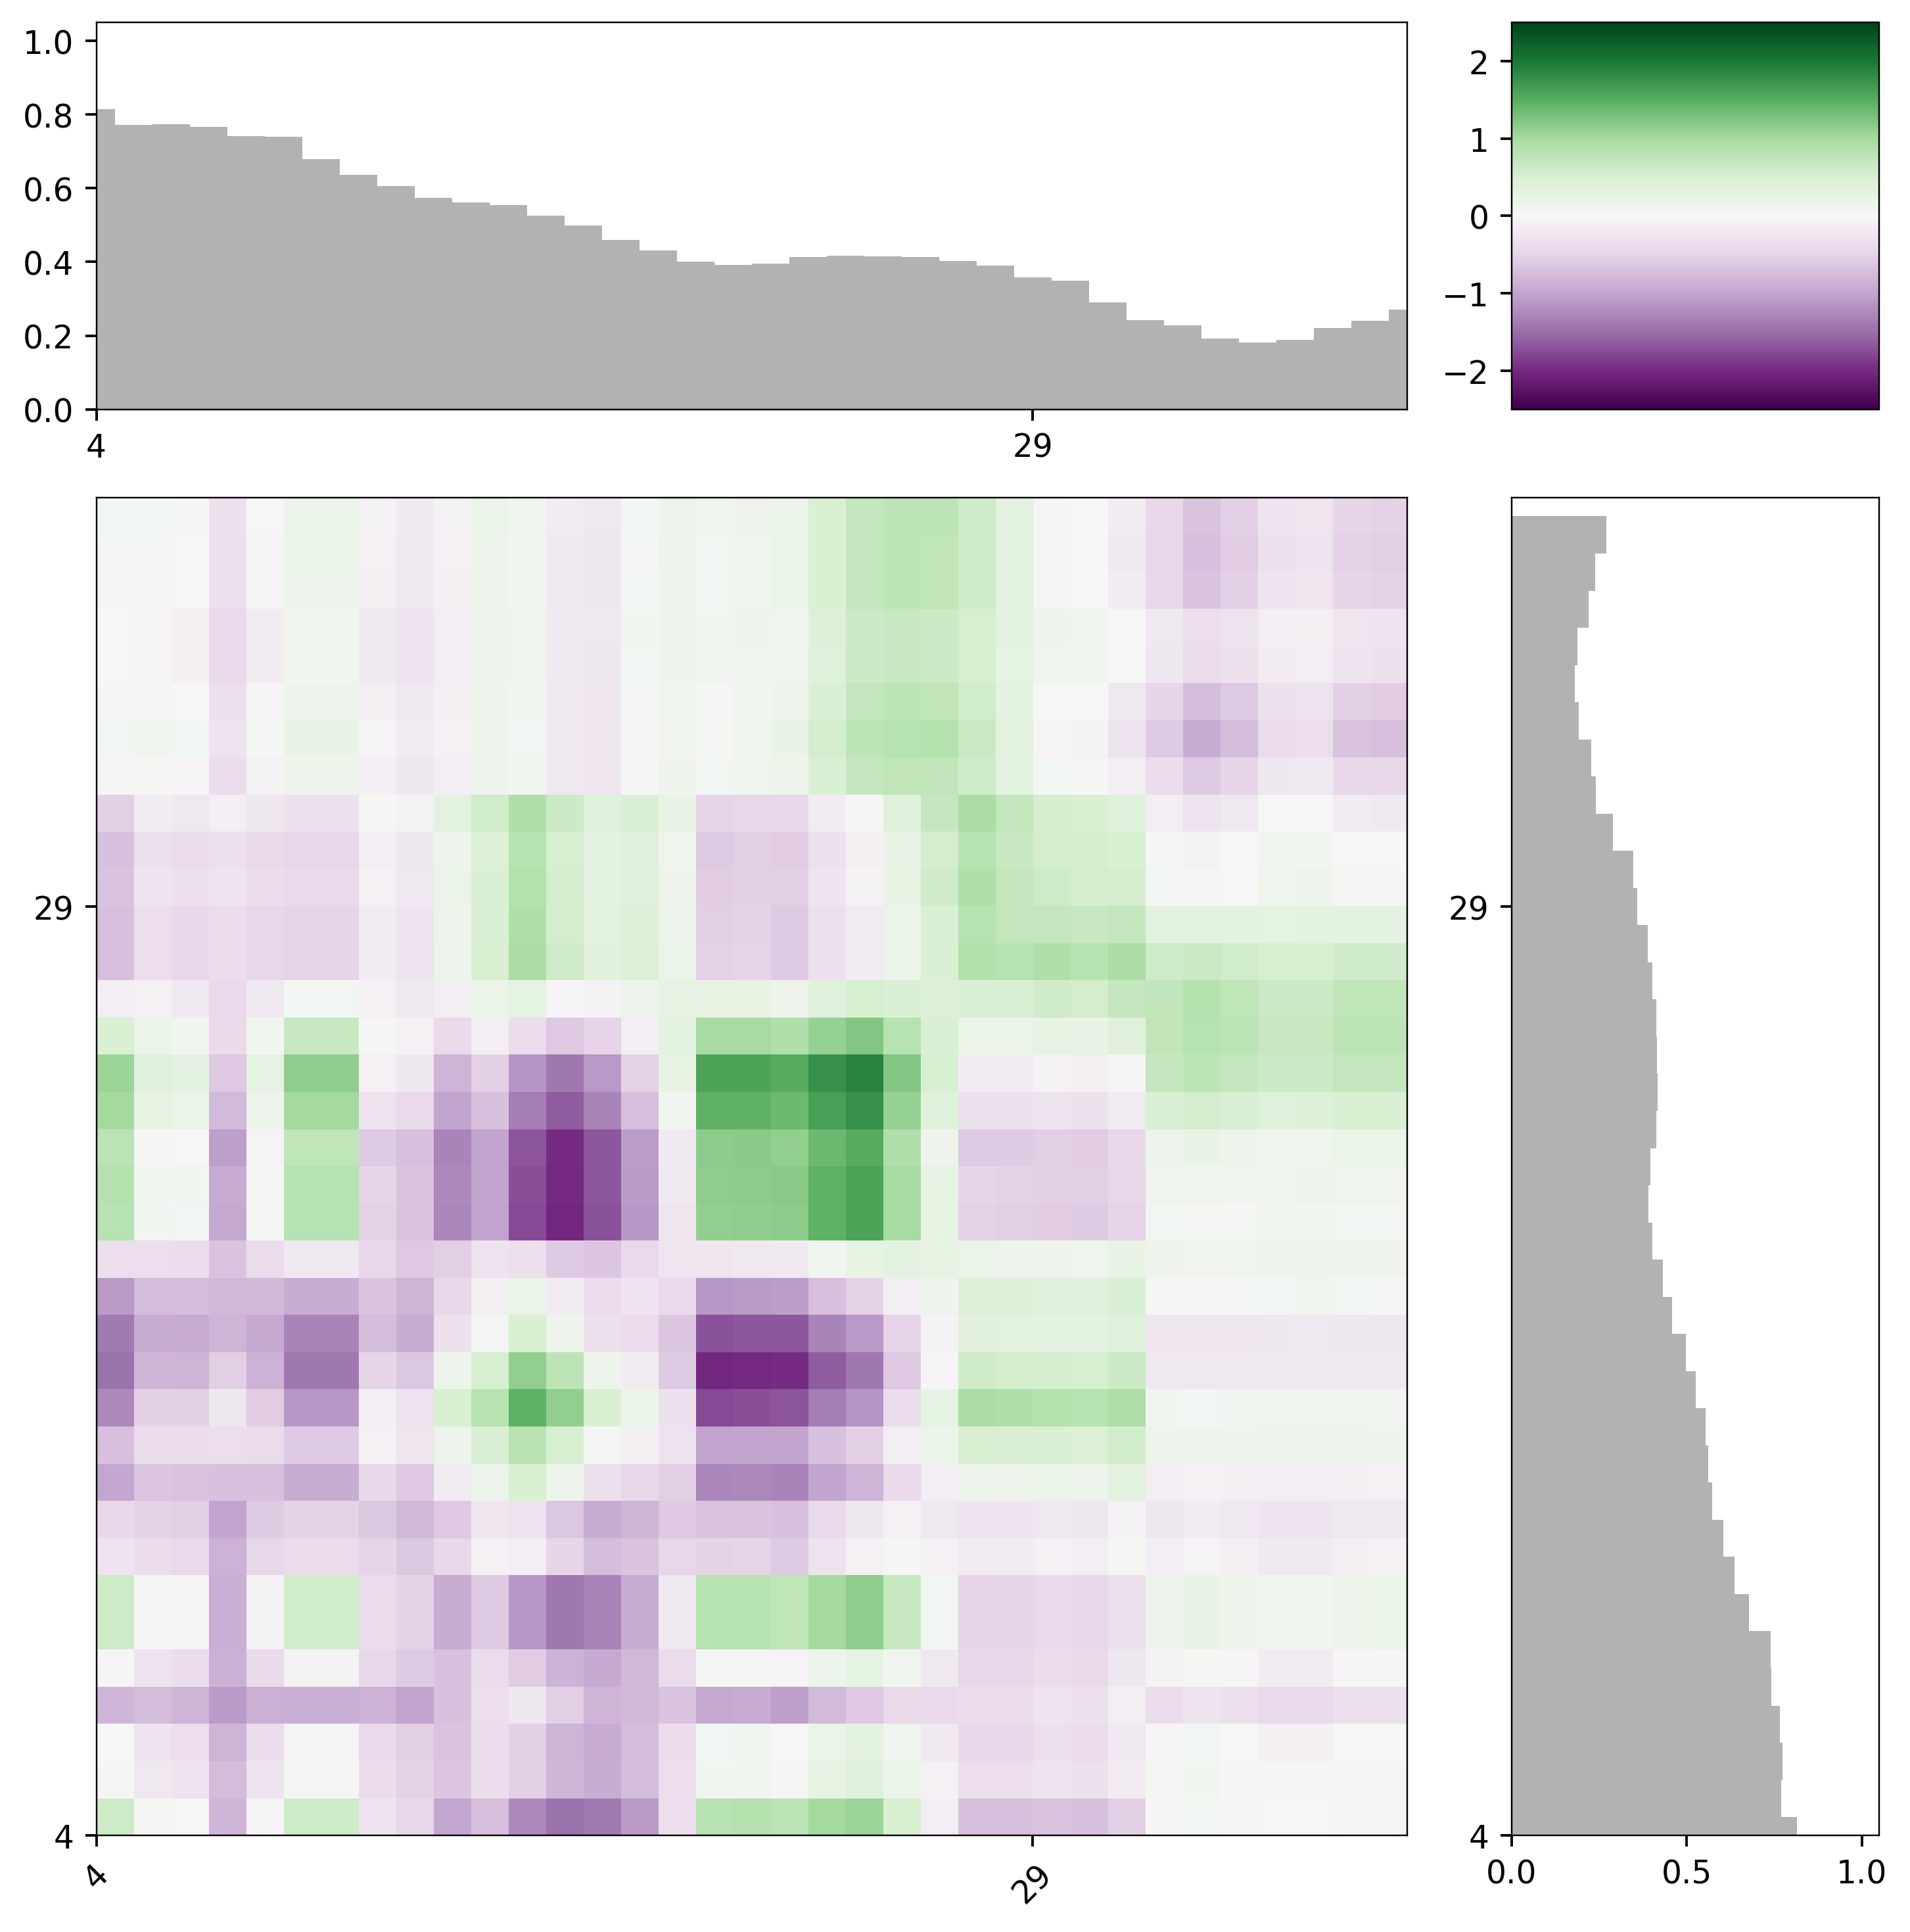

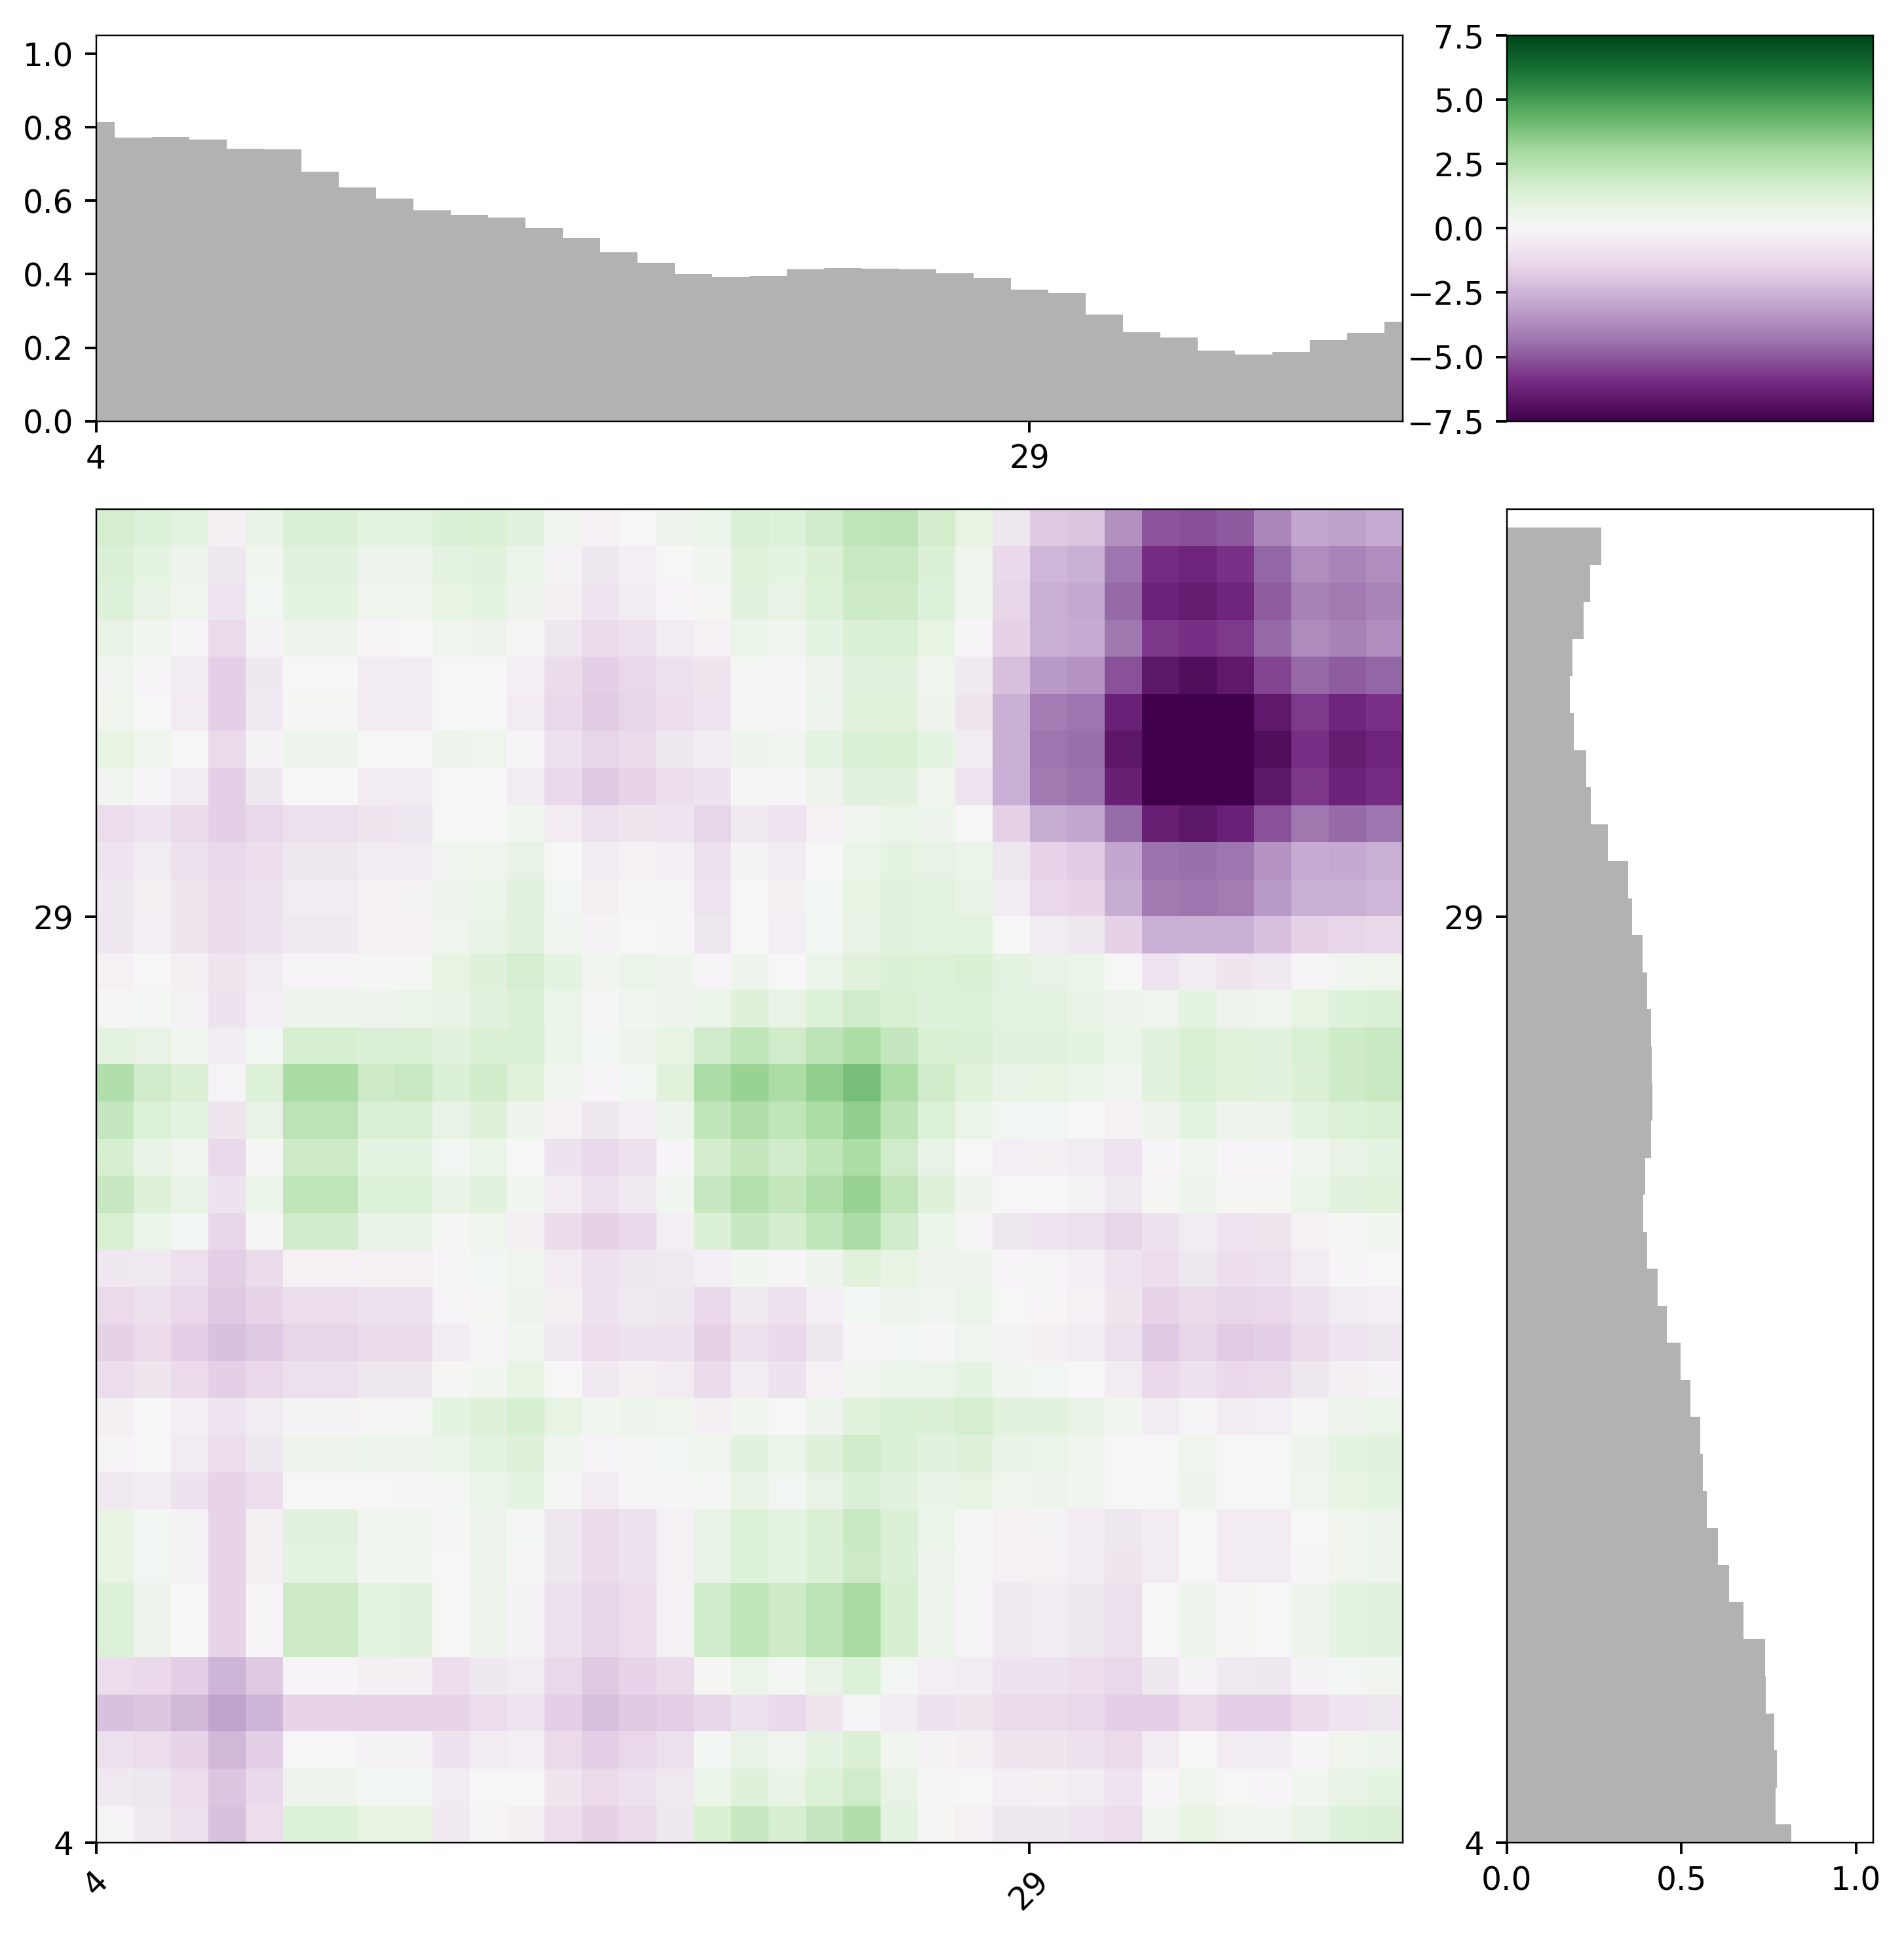

In [8]:
#@title Build intermap
#@markdown  This notebook will build an intermap between two sequences. This is
#@markdown  also doable using the [finches-online](http://finches-online.com/)
#@markdown webserver, but this notebook benefits from (1) having no real limitations
#@markdown in sequence length, and (2) Allowing you to download the raw values in the
#@markdown intermap for further analysis.

#@markdown **NOTE**: The first time this is executed finches is installed. However
#@markdown once installed the notebook can be re-run without needing to
#@markdown reinstall, so the FIRST analysis takes ~1 minute but all subsequent
#@markdown analyses take a few seconds.

# first check if init_done exists and initialize
# if not.
if 'init_done' not in globals():
    init_done = False

# init block - only runs once
if not init_done:
  print('Installing finches... this will take a minute or so')

  !pip install git+https://git@github.com/idptools/finches.git --quiet;

  # import
  from finches import Mpipi_frontend, CALVADOS_frontend
  from google.colab import files
  import pandas as pd

  # setup frontend objects
  cf = CALVADOS_frontend()
  mf = Mpipi_frontend()
  init_done = True
  print('Installation complete!')
else:
  print('Finches is ready to go!')

# --------------------------------
# start of code
# --------------------------------

#@markdown  -------
#@markdown  Define sequences of interest
sequence_1 = "" #@param {type:"string"}
sequence_2 = "" #@param {type:"string"}
#@markdown  - Each sequence should be 30 residues or longer. Note that the examples here are Sox2 and Nanog.


#@markdown  -------
#@markdown  ## Define parameters for predictions
use_mpipi = True #@param {type:"boolean"}
#@markdown  * If ticked an Mpipi-based intermap will be generated
mpipi_minmax = 2.5 #@param [1, 2, 2.5, 3.5, 6, 8, 12] {type:"raw"}
#@markdown  * **mpipi_minmax** defines the min and max range of the local $\epsilon$ values
use_calvados = True #@param {type:"boolean"}
#@markdown  * If ticked a CALVADOS-based intermap will be generated
calvados_minmax = 7.5 #@param [2, 5, 7.5, 9, 12, 16] {type:"raw"}
#@markdown  * **calvados_minmax** defines the min and max range of the local $\epsilon$ values

#@markdown  -------
#@markdown  ### Define some general properties of the figure
ticfreq = "25" #@param [10,25,50,100]
#@markdown  * **ticfreq** defines the tick-mark frequencies to be used.
zero_folded = "True" #@param ["True", "False"]
#@markdown  * **zero_folded** is a boolean which sets if the folded domains should be zeroed out or not
window_size = "31" #@param ["5", "7", "9", "11", "13", "15", "17", "19", "21", "23", "25", "27", "29", "31", "33", "35", "37", "39", "41", "43", "45"]
#@markdown  * **window_size** defines the size of the sliding window - note this must be smaller than the sequence!
download = "True" #@param ["True", "False"]
#@markdown  * **Download values** If set to true, means we automatically trigger the matrix plotted to be downloaded!


# validation
mpipi_minmax = abs(mpipi_minmax)
window_size = int(window_size)
ticfreq = int(ticfreq)

if zero_folded =='False':
  zero_folded = False
else:
  zero_folded = True

if download =='False':
  download = False
else:
  download = True


if len(sequence_1) < window_size or len(sequence_2) < window_size:
  raise Exception('To generate an intermap each sequence must be 31 residues or longer')


if use_mpipi:
  print('Generating Mpipi intermap')
  mf.interaction_figure(sequence_1,
                        sequence_2,
                        vmin=-mpipi_minmax,
                        vmax=mpipi_minmax,
                        tic_frequency=ticfreq,
                        zero_folded=zero_folded,
                        window_size=window_size)

if use_calvados:
  print('Generating CALVADOS intermap')
  cf.interaction_figure(sequence_1,
                        sequence_2,
                        vmin=-calvados_minmax,
                        vmax=calvados_minmax,
                        tic_frequency=ticfreq,
                        zero_folded=zero_folded,
                        window_size=window_size)

if download:
  output = {}
  outnames = {}
  if use_calvados:
    output['cf'] = cf.intermolecular_idr_matrix(sequence_1, sequence_2, window_size=window_size)[0]
    outnames['cf'] = 'cf_intermap_data.csv'
  if use_mpipi:
    output['mf'] = mf.intermolecular_idr_matrix(sequence_1, sequence_2, window_size=window_size)[0]
    outnames['mf'] = 'mf_intermap_data.csv'



  for name in output:
    B = output[name]
    df = pd.DataFrame(B[0])

    # Get the column and row indices
    column_indices = B[2]
    row_indices = B[1]

    # Insert the column indices as the first row
    df_with_columns = df.copy()
    df_with_columns.loc[-1] = [int(i) for i in column_indices]  # Add the column indices as a new row
    df_with_columns.index = df_with_columns.index + 1  # Shift the index
    df_with_columns = df_with_columns.sort_index()  # Sort by index to put the new row at the top

    # Insert the row indices as the first column
    df_with_indices = df_with_columns.copy()
    df_with_indices.insert(0, '', [''] + list(row_indices))  # Add the row indices and an empty string at the start

    # Save the DataFrame to a CSV file [this overwrite if exists]
    csv_file = outnames[name]
    df_with_indices.to_csv(csv_file, index=False, header=False)

    # Use google.colab.files to trigger the download
    files.download(csv_file)


#@markdown  ## Intermaps below
#@markdown  Intermaps are shown below - if both Mpipi and CALVADOS-based intermaps are generated then Mpipi intermap is first, CALVADOS second.
#@markdown  sequence_1 is along the x-axis and sequence_2 along the y-axis.